# Python初級編３：線形回帰
## 目次
* [線形回帰](#線形回帰)
 * [課題9.1: 人工データの生成](#課題9.1:-人工データの生成)
 * [課題9.2: 正規方程式を解いて最適パラメータを見つける](#課題9.2:-正規方程式を解いて最適パラメータを見つける)
  * [`plt.legend` について](#`plt.legend`-について)
 * [課題9.3: 勾配法によってパラメータを見つける](#課題9.3:-勾配法によってパラメータを見つける)
* [課題提出の前の注意](#課題提出の前の注意)
 * [チャレンジ課題9.4: パラメータ推定値のゆらぎ](#チャレンジ課題9.4:-パラメータ推定値のゆらぎ)
* [課題提出の前の注意](#課題提出の前の注意)

---
このノートブックでは線形回帰を題材としてプログラミングの練習を行う．

## 線形回帰
実数の組からなるデータ $(x_1, y_1), (x_2, y_2), \dots, (x_N, y_N)$ に対して，$x_i$ と $y_i$ の間に，ある関数関係 $y_i = f(x_i)$ を当てはめる問題を**回帰**という．

例えば $x$ として前日の博多の気温，$y$ として翌日の東京の気温の観測値を集めたデータ $(x_1, y_1), \dots, (x_N, y_N)$ があるとする．このときに，$x$ と $y$ の関係を回帰によって推定することで，新しい入力 $x$ （例：今日の博多の気温）が与えられた時にそれに対する $y$ （例：明日の東京の気温）を予測することができる．

回帰で当てはめる関数のタイプとして最も基本的なものは一次関数 $y = ax + b$ である．
考える関数の範囲を一次関数に限定し，観測データを説明する上で最も適切な $a$ と $b$ を見つけることを**線形回帰**という．

回帰が難しい理由は，簡単な関数関係 $y = f(x)$ にピッタリ合うようなデータは現実にはほぼ存在しないことにある．
そこで回帰は「だいたい関数関係にあるけど少し乱れているデータ」から，乱れ（ノイズ）の影響を取り除いて「真の関数関係」を見つけ出そうとすることだともいえる．

以下では線形回帰のパラメータ推定を行う．この場合のパラメータ推定とは，与えられたデータを $y = ax + b$ の関係としてなるべく良く説明する $a$ と $b$ を見つける処理のことである．

パラメータ推定プログラムのテストのために，まず「だいたい一次関数の関係だけど少し乱れたデータ」を人工的に作っておく．

### 課題9.1: 人工データの生成
以下の処理を $N$ 回繰り返すことによって，「だいたい $y = ax + b$」の関係にある $(x,y)$ のタプルからなるリスト `[(x1, y1), (x2, y2), ..., (x_N, y_N)]` を作る：
1. $x_{\text{min}} \le x \le x_{\text{max}}$ の範囲の一様分布から $x$ を一つ生成する
2. ${\hat y} = ax + b$ を計算する
3. 平均 0，標準偏差 $\sigma$ の正規分布から乱数 $\epsilon$ を生成する
4. ${\hat y}$ に「乱れ」$\epsilon$ を加えて $y = {\hat y} + \epsilon$ とし，`(x, y)` をリストに加える

ヒント:
* $A \le x \le B$ の範囲の一様分布から乱数 $x$ を得るのは `x = random.uniform(A, B)` でできる
* 平均 `mu`, 標準偏差 `sigma` の正規分布から乱数 `eps` を得るのは `eps = random.gauss(mu, sigma)` でできる
* リスト `xys` にタプル `(x, y)` を追加するのは `append` メソッドを使って `xys.append((x, y))` でできる．カッコの数に注意せよ．

引数として `a`, `b`, `N` および `x_min` ($x$ の範囲の下限），`x_max`（$x$の範囲の上限），`sigma` （$\epsilon$ の標準偏差）を受け取り，上記のようにして作った `N` 個の `(x, y)` からなるリストを返す関数 `gen_xys(a, b, N, x_min, x_max, sigma)` を実装せよ：

In [62]:
import random

def gen_xys(a, b, N, x_min, x_max, sigma):
    xys = []
    # *** 実装しなさい ***
    for i in range (N):
        x = random.uniform(x_min, x_max)
        z = a * x + b
        eps = random.gauss(0, sigma)
        y = z + eps
        xys.append((x, y))
    return xys

実装できたら，`a = 0.5`，`b = 1.0`，`N = 200`，`x_min = -10`，`x_max = 10`，`sigma = 3` としてデータを200個生成して変数 `xys` に格納しなさい:

In [63]:
true_a = 0.5
true_b = 1.0

N = 200

x_min = -10
x_max = 10

sigma = 3

xys = gen_xys(true_a, true_b, N, x_min, x_max, sigma)

作ったデータの先頭10個を見てみなさい：

In [64]:
xys[:10]

[(4.513898021763046, 2.4519051354034422),
 (-9.193930069122057, -5.308546261512871),
 (8.956027360407063, 5.912827493896587),
 (5.879367601230101, 0.8790841653296195),
 (8.227999465508312, -3.6214419910913964),
 (-3.4398269148044953, -2.2182970729707656),
 (6.580199213725557, 7.813342166327479),
 (6.318797095500447, 4.572958299356547),
 (6.986116364150114, 4.390015568362735),
 (-7.864017441559323, -3.057723924603619)]

作ったデータ全体を見て確認するために `plt.scatter(xs, ys)` で散布図を描きたい．
そのために，`xys` の各要素 `(x, y)` のうち `x` を集めたリスト `xs` と，`y` を集めたリスト `ys` を作りたい．

リストと同様に，タプルの場合も `xy[i]` のように添え字演算子を使って `i` 番目（ゼロ始まり）の要素を取り出せる．
よって先ほど作ったデータ `xys` の各要素 `(x, y)` の `x` のほうと `y` のほうをそれぞれ取り出すとき，
```python
for xy in xys:
    x = xy[0]
    y = xy[1]
    ...
```
とすると，変数 `xy` にはループの各回ごとに `xys` の要素 `(x, y)` がセットされ，添え字を使ってそのゼロ番目の要素 `x` と1番目の要素 `y` が取り出せる．

これと同じことを、添え字を使わずにすることもできる．それには，`for` の後に変数をカンマで区切って2つ書けばよい：
```python
for x, y in xys:
    ...
```
こうするとループの各回では `xys` の中のそれぞれのタプルのゼロ番目と1番目の要素がそれぞれ `x`，`y` にセットされる．

`for x, y in xys:` の書き方を使って `xys` の `x` と `y` をそれぞれリスト `xs`, `ys` に集め，`plt.scatter(xs, ys)` で散布図を描きなさい：

ヒント（ダブルクリックで表示）
<!--
scatter の使い方を覚えてない人のために

「xys の x と y をそれぞれリスト xs, ys に集める」

というのがどういうことか例を挙げると

xys = [(1, 2), (3, 4), (5, 6)]

だとすると

xs = [1, 3, 5]
ys = [2, 4, 6]

というリストを作る，ということ．
-->

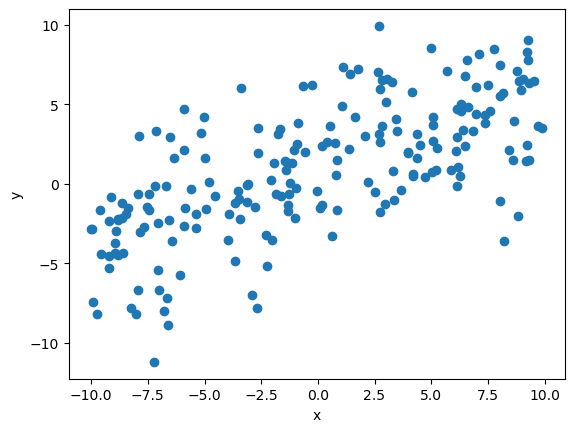

In [65]:
import matplotlib.pyplot as plt

# xys = [(x0, y0), ...] の各要素の
# 第0成分を集めるリスト xs と
# 第1成分を集めるリスト ys を初期化
xs = []
ys = []

# 成分ごとにリストを作る処理
# *** 実装しなさい ***
for x, y in xys:
    xs.append(x)
    ys.append(y)
    
# 散布図を表示する
plt.xlabel("x") # 横軸の名前を設定
plt.ylabel("y") # 縦軸の名前を設定
plt.scatter(xs, ys);

---
### 課題9.2: 正規方程式を解いて最適パラメータを見つける

次に上で生成したデータ `xys` に対して一次関数 $y = ax + b$ を当てはめることを考える．

以下，`xys` の中身が $[(x_1, y_1), (x_2, y_2), \dots, (x_N, y_N)]$ であるとする．

関数 $y = ax + b$ のこのデータへの当てはまり具合を測る尺度はいくつか考えられるが，ここでは平均2乗誤差を用いることにする．

ここでの平均2乗誤差とは，
* $x_i$ に対する，関数 $y = ax + b$ による $y$ の予測値である $a x_i + b$
* データ上の「実測値」である $y_i$

の間の差の2乗の平均値（の 1/2）である．式でかけば以下の通り：
$$
E = \frac{1}{2N}\sum_{i=1}^{N} \{y_i - (a x_i + b)\}^2.
$$
この $E$ が小さければ小さいほど，関数 $y = ax + b$ がデータに良く当てはまっていると考える．実際，$E = 0$ はデータが直線 $y = ax + b$ にピッタリ乗っていることを意味する．平均をさらに 2 で割って $\Sigma$ の前が $\frac{1}{2N}$ となっているのは後の計算の都合である．

これから $E$ が最小となるような $a$, $b$ を探す．このとき，$E$ は（$x_i$ や $y_i$ ではなく）$a$ と $b$ の関数と考えていることに注意せよ．

まず $E$ を $a$, $b$ でそれぞれ偏微分し，$a$, $b$ について整理すると以下のようになる：
$$
\begin{align}
\frac{\partial E}{\partial a} &= \frac{1}{N}\sum_{i=1}^{N} -x_i\{y_i - (a x_i + b)\} 
                              = \left(\frac{1}{N}\sum_{i=1}^{N} x_i^2\right)a + \left(\frac{1}{N}\sum_{i=1}^{N}x_i\right)b - \frac{1}{N}\sum_{i=1}^{N}x_i y_i
\\
\frac{\partial E}{\partial b} &= \frac{1}{N}\sum_{i=1}^{N} -\{y_i - (a x_i + b)\}
                              = \left(\frac{1}{N}\sum_{i=1}^{N} x_i\right)a + b - \frac{1}{N}\sum_{i=1}^{N}y_i
\end{align}
$$

$E$ は $a$, $b$ に関して下に凸である．つまり $ab$-平面上の各点 $(a, b)$ の真上に，対応する値 $E$ を高さとする点をとって $E$ の（3次元）グラフを描けばお茶碗のような形になる．よって $E$ が最も小さくなる $a$, $b$ は，上の2式をそれぞれゼロと置いた $a$, $b$ の連立方程式

$$
\left\{
\begin{array}{l}
\left(\sum_{i=1}^{N} x_i^2\right)a + \left(\sum_{i=1}^{N}x_i\right)b = \sum_{i=1}^{N}x_i y_i \\
\left(\sum_{i=1}^{N} x_i\right)a + N b = \sum_{i=1}^{N}y_i
\end{array}
\right.
$$
を解けば得られる．

この連立方程式のことを「正規方程式」という．与えられた `xys` に対し正規方程式を解いて最適な $a$, $b$ を求め，タプル `(a, b)` として返す関数 `opt_ab(xys)` を実装せよ．

In [66]:
def opt_ab(xys):
    # *** 実装しなさい ***
    p=0
    q=0
    r=0
    s=0
    t=0
    for x,y in xys:
        p+=x
        q+=y
        r+=x**2
        s+=y**2
        t+=x*y
        N=len(xys)
        k=r*N-p**2
        a=1/k*(N*t+(-p)*q)
        b=1/k*((-p)*t+r*q) 
    # 最後にパラメータ a, b をタプルとして返す
    return (a, b)

ヒント（ダブルクリックで表示）
<!--
* まず正規方程式（a と b の連立1次方程式）の係数と，右辺の定数である以下の4つの和をループを使って求める
  - x_i の和
  - y_i の和
  - x_i^2 の和
  - x_i * y_i の和

* 係数 N はデータ数だから len(xys) と等しい

* 次に2次正方行列の逆行列の公式

A = [p q]
    [r s]
→
A^-1 = 1/(det A) [ s -q]
                 [-r  p]

を使って正規方程式を解けばよい
-->

テストとして，データが2つだけの場合を試してみよう．例えばデータが `[(1, 2), (3, 4)]` であれば直線 $y = x + 1$ がぴったり当てはまるから `(a, b)` として `(1.0, 1.0)` が得られるはずである：

In [67]:
opt_ab([(1, 2), (3, 4)])

(1.0, 1.0)

正しく実装できていそうだったら `xys` に基づく推定値 `(est_a, est_b) = opt_ab(xys)` と，訓練データの生成に用いた「真の値」`(true_a, true_b)` を比べなさい：

In [68]:
(est_a, est_b) = opt_ab(xys)
print("     true (a, b) =", (true_a, true_b))
print("estimated (a, b) =", (est_a, est_b))

     true (a, b) = (0.5, 1.0)
estimated (a, b) = (0.46943209236115574, 0.9730301932821863)


さらに，`xys` の散布図に，「真の値」による直線 $y = ax + b$ および上で得た推定値による直線 $y = ax + b$ を重ねてみなさい．

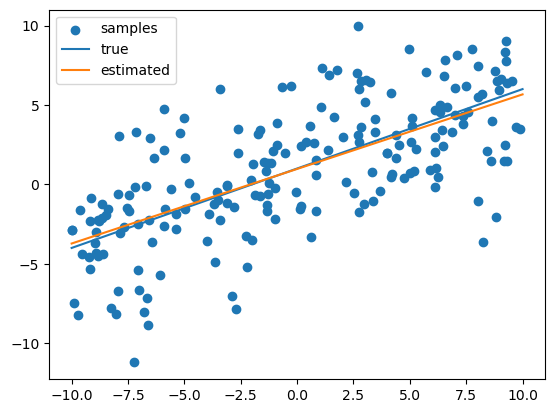

In [69]:
# xys の散布図
plt.scatter(xs, ys)

# 真の直線 y = true_a * x + true_b のグラフ
plt.plot([x_min, x_max], [true_a * x_min + true_b, true_a * x_max + true_b])

# 推定値による直線 y = est_a * x + est_b のグラフ
plt.plot([x_min, x_max], [ est_a * x_min +  est_b,  est_a * x_max +  est_b])

# 凡例
plt.legend(["samples", "true", "estimated"]);

推定値による直線が，データに対しておおよそ妥当なものになっていることを確かめなさい．そうでなければどこかで間違っている．

#### `plt.legend` について
上のセルでは二つの直線のグラフに `plt.legend` を使って凡例をつけた．

`plt.scatter` や `plt.plot` を使っていくつかの散布図やグラフを描いた後
```python
plt.legend(["名前1", "名前2", ...])
```
を実行すると，描いた順番に散布図上の点やグラフに「名前1」「名前2」...が与えられる．

### 課題9.3: 勾配法によってパラメータを見つける
最適なパラメータを求める別の方法として，適当な初期値を $a$, $b$ に与え，$E$ が減少するように少しずつ $a$, $b$ を動かしていくことで良い $a$, $b$ を得るという方法（勾配法）がある．

$E$ を $a, b$ の2変数関数と考えて点 $(a, b)$ の周りでテーラー展開し，$(a, b)$ が $(a + \Delta a, b + \Delta b)$ へと変化したときの $E$ の変化をパラメータ $a, b$ の変化量 $\Delta a, \Delta b$ の一次関数として近似すると以下のようになる：

$$
E(a + \Delta a, b + \Delta b) - E(a, b) = \frac{\partial E}{\partial a}\Delta a + \frac{\partial E}{\partial b}\Delta b + o\left(\sqrt{(\Delta a)^2 + (\Delta b)^2}\right)
$$

よって $E$ が減少するように $a$, $b$ を動かすためには，現在の $a$, $b$ の値を用いて偏微分係数 $\displaystyle \frac{\partial E}{\partial a}, \frac{\partial E}{\partial b}$ を計算し，ベクトル $[a, b]$ をベクトル $\displaystyle \left[\frac{\partial E}{\partial a}, \frac{\partial E}{\partial b}\right]$ と**逆の方向**に少しだけ動かせばよい．

つまり勾配法とは以下の2ステップを繰り返す方法である：
1. $E$ の偏微分係数
$$
\begin{align}
\frac{\partial E}{\partial a} &= \frac{1}{N}\sum_{i=1}^{N} -x_i\{y_i - (a x_i + b)\} 
\\
\frac{\partial E}{\partial b} &= \frac{1}{N}\sum_{i=1}^{N} -\{y_i - (a x_i + b)\}
\end{align}
$$
を，データ `xys` および現在の $a$, $b$ の値を使って計算する
2. $\eta$ を小さな定数として，更新式
$$
\left[\begin{array}{c} a \\ b \end{array} \right] \leftarrow
\left[\begin{array}{c} a \\ b \end{array} \right]
- \eta
\left[\begin{array}{c} \frac{\partial E}{\partial a} \\
                       \frac{\partial E}{\partial b} \end{array}\right]
$$
に従って $a$, $b$ の値を変更する．

$\eta$ を小さくして，$a$，$b$ を十分ゆっくり動かしていけば，やがて $E$ の極小点のすぐそばで偏微分係数は $\displaystyle \left[\frac{\partial E}{\partial a}, \frac{\partial E}{\partial b}\right] = [0, 0]$ に非常に近くなる．なので，そこで更新は実質的に止まり，そのときの $a$, $b$ は最適値にごく近いことが期待できる．

正規方程式を解くのに比べると，なんとなくいい加減な方法なような気がするが，入力がベクトル ${\bf x} = [x^{(1)}, x^{(2)}, \dots, x^{(M)}]$ になった形の線形回帰モデル

$$
y = a^{(1)}x^{(1)} + a^{(2)}x^{(2)} + \cdots + a^{(M)}x^{(M)} + b
$$

で，入力の次元 $M$ が非常に大きく，従ってパラメータ $a^{(1)}, \cdots, a^{(M)}, b$ も非常に多数になるような場合には有力な手段になる．

---
勾配法で単回帰モデル $y = ax + b$ のパラメータを求めるために，まずは現在の $a$, $b$ およびデータ `xys` を入力とし，上のステップ 1. の式に従って計算した偏微分係数を並べたリスト（タプルでもよい） $\displaystyle \left[\frac{\partial E}{\partial a}, \frac{\partial E}{\partial b}\right]$ を返す関数 `partial(a, b, xys)` を実装しなさい：

In [70]:
def partial(a, b, xys):
    # *** 実装しなさい ***
    p=[]
    q=0
    r=0
    N=len(xys)
    for x,y in xys:
        q += -x*(y-(a*x+b))
        r += -(y-(a*x+b))
        s = q/N
        t = r/N
    p.append(s)
    p.append(t)
    return p

ヒント（ダブルクリックで表示）
<!--
リスト xys に関するループを使って偏微分 ∂E/∂a，∂E/∂b の式の ∑ のところを計算し，最後に N = len(xys) で割ればよい．
-->

実装できたら，テストとして前の課題で正規方程式を解いて求めた $a$, $b$ の最適値を `partial` に入力したときに，ほぼゼロベクトルに近い結果が返ってくることを確認しなさい：

In [71]:
partial(est_a, est_b, xys)

[-6.085132397970483e-15, -2.914335439641036e-17]

例えば `1.23e-14` というのは $1.23 \times 10^{-14}$ の意味である．

---
次に，更新の回数 `num_iter`，データ `xys`，更新の大きさを決める係数 `eta` (上の更新式の $\eta$), および $a$, $b$ の初期値 `a0`，`b0` を受けとって，`num_iter` 回の更新後の結果を2要素のリスト $[a, b]$ として返す関数 `grad_desc(num_iter, xys, eta, a0, b0)` を実装しなさい： 

In [72]:
def grad_desc(num_iter, xys, eta, a0, b0):
    # *** 実装しなさい ***
    a=a0
    b=b0
    for _ in range(num_iter):
        s = partial(a,b,xys)
        k = s[0]
        t = s[1]
        a = a-eta*k
        b = b-eta*t
    return [a,b]

ヒント（ダブルクリックで表示）
<!--
以下のようにすればよい
1. 変数 a, b を a0, b0 で初期化する
2. 以下の（for ループを使って）num_iter 回繰り返す
   2.1 partial(a, b, xys) を使って偏微分係数 ∂E/∂a，∂E/∂b を計算する
   2.2 以下のようにパラメータ a, b を更新する
       a = a - eta * ∂E/∂a
       b = b - eta * ∂E/∂b 
3. 最後に return [a, b] する
-->

実装できたら，`eta = 0.01`, `a0 = b0 = 0` とし，`num_iter` を 10, 100, 500, 1000 とした場合の勾配法による結果（GD @ 10/100/...）を，正規方程式を解いた結果（normal eq）およびデータの生成に使った「真の値」（true a, b）と比べてみなさい：

In [73]:
print("GD @ 10  : ", grad_desc(10, xys, 0.01, 0, 0))
print("GD @ 100 : ", grad_desc(100, xys, 0.01, 0, 0))
print("GD @ 500 : ", grad_desc(500, xys, 0.01, 0, 0))
print("GD @ 1000: ", grad_desc(1000, xys, 0.01, 0, 0))
print("normal eq: ", opt_ab(xys))
print("true a, b: ", [true_a, true_b])

GD @ 10  :  [0.46135739161629535, 0.09201004650181932]
GD @ 100 :  [0.4685662688707066, 0.6163816625895967]
GD @ 500 :  [0.4694165376238893, 0.9666229125227065]
GD @ 1000:  [0.4694319900543975, 0.9729880512573154]
normal eq:  (0.46943209236115574, 0.9730301932821863)
true a, b:  [0.5, 1.0]


更新を500〜1000回ほど行えば正規方程式を解いて得たパラメータ $a, b$ の値とかなり近いものが得られることが分かる．

---
より詳しく，勾配法による結果の変化を各更新ステップごとに見てみよう．

具体的には，各更新ステップの後の $a$, $b$ の値に対する2乗誤差をグラフにして調べたい．

まず，ある $a$, $b$ の値およびデータ `xys = [(x1, y1), (x2, y2), ...]` を入力とし，2乗誤差
$$
E' = \frac{1}{N}\sum_{i=1}^{N} \{y_i - (a x_i + b)\}^2
$$
を返す関数 `mse(a, b, xys)` を実装しなさい（mse は mean squared error の略；ここまでの $E$ とは係数 1/2 の分だけ違うことに注意．これは以下で真の分散 $\sigma^2$ と比較するため）：

In [74]:
def mse(a, b, xys):
    # *** 実装しなさい ***
    p=0
    N=len(xys)
    for x,y in xys:
        p += (y-(a*x+b))**2
        r = p/N
    return r

実装できたら，ひとまずテストとして真の値 `a = true_a`，`b = true_b` に対して誤差がその期待値 $\sigma^2$ と近い値（$\sigma$ はデータ `xys` の生成に使った正規分布の標準偏差）になっていることを確かめなさい（`xys` のデータ数が少ないため ±2 くらいはずれるかもしれない）：

In [75]:
print("平均2乗誤差E':", mse(true_a, true_b, xys))
print("真のσ^2     :", sigma ** 2)

平均2乗誤差E': 9.231493166540643
真のσ^2     : 9


次に，`grad_desc` を一部変更して，最終的な $a$, $b$ の値ではなく，各更新ステップの後の $a$, $b$ の値に対する平均２乗誤差 $E'$ の値のリスト（長さは `num_iter` になる）を返す関数 `grad_desc_steps(num_iter, xys, eta, a0, b0)` を実装しなさい（入力の意味は `grad_desc` と同じ）．

つまり，パラメータ `(a, b)` の値が更新によって
```python
(a0, b0) --> (a1, b1) --> (a2, b2) --> ... --> (an, bn)
```
と変化したとして（ここで `n = num_iter`），パラメータの値が `(a, b) = (ai, bi)` のときの平均2乗誤差を `Ei` とすれば
```python
[E1, E2, ..., En]
```
というグラフを返しなさい．

In [76]:
def grad_desc_steps(num_iter, xys, eta, a0, b0):
    # *** 実装しなさい ***
    a = a0
    b = b0
    k = []
    for _ in range(num_iter):
        k.append(mse(a,b,xys))
        a = a-eta*partial(a,b,xys)[0]
        b = b-eta*partial(a,b,xys)[1]
    return k

実装できたら，まず `eta = 0.01`，`a0 = b0 = 0` の場合の1000 更新ステップまでの2乗誤差の値をプロットしてみなさい：

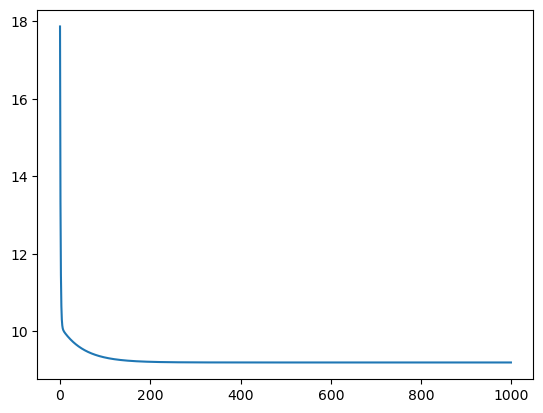

In [77]:
plt.plot(grad_desc_steps(1000, xys, 0.01, 0, 0));

`eta = 0.01` だと更新回数200ほどでほぼ収束しているように見えるはずである．

さらに，`eta = 0.05, 0.01, 0.005, 0.001` のそれぞれに対する各更新ステップ後の2乗誤差の値を 1000 更新ステップまでグラフにしてみなさい．ヒストグラムの重ねがきと同じように，ひとつのセルで何度か `plt.plot` を呼び出せば，それらの結果は重ねて描かれる：

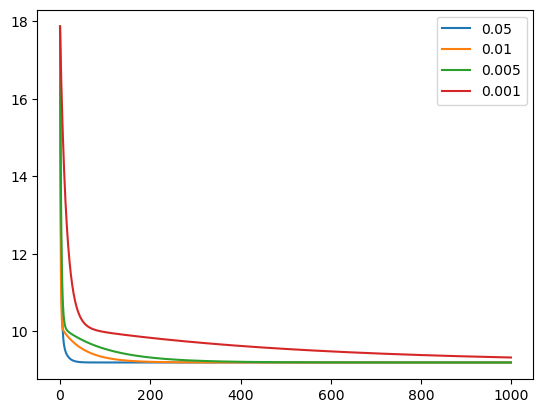

In [78]:
# *** 実装しなさい ***
plt.plot(grad_desc_steps(1000, xys, 0.05, 0, 0));
plt.plot(grad_desc_steps(1000, xys, 0.01, 0, 0));
plt.plot(grad_desc_steps(1000, xys, 0.005, 0, 0));
plt.plot(grad_desc_steps(1000, xys, 0.001, 0, 0));
# 0.05, ..., 0.001 の順でグラフを描いた場合の凡例
# 違う順番で書いた場合は legend の引数のリスト内の順番を合わせる
plt.legend([0.05, 0.01, 0.005, 0.001]);

$\eta$ の値が大きい（⇔ 更新の幅が大きい）ほど，収束が速い様子が見て取れるだろう．

では，さらに大きな $\eta$ を使ったらどうなるだろうか．
`eta = 0.1`，`a0 = b0 = 0` の場合の1000 更新ステップまでの2乗誤差の値をプロットしてみなさい：

In [79]:
# *** 実装しなさい ***
#plt.plot(grad_desc_steps(1000, xys, 0.1, 0, 0));

エラーメッセージが出て止まってしまったはずだ．エラーメッセージを確認したら．コメントアウトしてあとで Run All Cells するときにエラーにならないようにしなさい．

どうしてこうなるのか，詳しく見るために，各ステップの更新後に $a$, $b$ の値を
```
  Step 1: a=1.6047481378289519, b=0.07402399948679292
  Step 2: a=-2.132688226121231, b=0.19224771800685003
  ...
```
のように表示するように `grad_desc` を修正した関数 `grad_desc_report` を実装しなさい：

In [80]:
def grad_desc_report(num_iter, xys, eta, a0, b0):
    # *** 実装しなさい ***
    a = a0
    b = b0
    for k in range(num_iter):
        a = a-eta*partial(a,b,xys)[0]
        b = b-eta*partial(a,b,xys)[1]
        print("Step {}:a={},b={}".format(k+1,a,b)) 

実装できたら，さきほどと同じ，`eta = 0.1`，`a0 = b0 = 0` で，100ステップまで実行してみなさい：

In [81]:
grad_desc_report(100, xys, 0.1, 0, 0)

Step 1:a=1.6524186911360372,b=0.10717474594432322
Step 2:a=-2.5394260865343083,b=0.1686521234347555
Step 3:a=8.097199732560288,b=0.3127417392508042
Step 4:a=-18.890276628212476,b=0.2172186684658482
Step 5:a=49.58518387999666,b=0.7026584572956122
Step 6:a=-124.15592066687486,b=-0.3102716968411857
Step 7:a=316.6749432566895,b=2.45671421654919
Step 8:a=-801.837372148589,b=-4.386703345175776
Step 9:a=2036.145523274396,b=13.136476687004912
Step 10:a=-5164.620454138707,b=-31.18124828001749
Step 11:a=13105.76240987392,b=81.39456423658413
Step 12:a=-33251.37282847917,b=-204.12587727188725
Step 13:a=84369.80792232402,b=520.4249934989948
Step 14:a=-214068.43787515702,b=-1317.8715715908527
Step 15:a=543153.9099927901,b=3346.4921925497692
Step 16:a=-1378133.632652245,b=-8488.243335399102
Step 17:a=3496716.974172191,b=21539.90097753117
Step 18:a=-8872159.578808298,b=-54649.943349753536
Step 19:a=22511183.11711163,b=138665.32438763854
Step 20:a=-57117245.10311171,b=-351830.2069195973
Step 21:a=14492

$a$, $b$ の値の絶対値が急激に大きくなっていく様子が分かるだろう．
符号にも気を付けて見てみること．

どうしてそのようになるのか，考えてみなさい（これは課題ではない）．

ここまでで，$\eta$ を大きくすれば収束が速くなるからといって，いくらでも $\eta$ を増やせるというものではないことが分かった．

---
お疲れ様でした．以上で今回の必須課題は終わりです．

## 課題提出の前の注意
* かならずメニューの "Run" から <font color="red">"Run All Above Selected Cells"</font> を選択し，ここまでの全てのセルが正しく実行されることを確認すること
  * ”Run All **Above Selected Cells**" ではなく "Run All Cells" を選択すると，下のチャレンジ課題のセルが実行されてエラーになります．必須課題のところが正しく実行されていれば問題はありませんが．
* "Run All Above Selected Cells" を実行したら，各セルの実行結果が表示されている状態で保存のボタンを押してノートブックを保存すること
* 上記のようにして，実行結果まで含めて保存してからノートブックを提出すること．

### チャレンジ課題9.4: パラメータ推定値のゆらぎ
線形回帰モデル $y = ax + b$ のパラメータ $a$, $b$ を推定する際に，用いるデータ点 $(x_1, y_1), (x_2, y_2), \dots, (x_N, y_N)$ の数 $N$ が多いほど $a$, $b$ の推定値が正確になることは想像できるだろう．これは正規方程式を解いて推定値を得る場合でも，勾配法を用いる場合でも同様である．

ここでは実際に，推定のために与えるデータの数を変化させて，パラメータ $a$ の推定値がどれくらい「バラつくか」を調べてみよう．

$N$個のデータ点をランダムに得るとき，それらに基づく $a$ の推定値のバラツキを見るには，
* $N$個のデータ点を生成する
* それらに基づき推定値 $a$ を計算する

ということを $K$ 回くり返し，$K$個の推定値のヒストグラムを描いてみればよい．

さらに，異なる $N$ に対する $a$ のバラツキの違いを見るために以下のようにしてみよう：
```
    N = 10, 20, 40, 80 のそれぞれについて以下を繰り返す
        k = 1, 2, ..., K について以下を繰り返す
            gen_xys を用いて N 個のデータを得る
            opt_ab を用いて a の推定値を得て，リストに保存する
        plt.hist を用いて a の K 個の推定値のヒストグラムを描く
```

以下すこし注意点：
*  `gen_xys(a, b, N, x_min, x_max, sigma)` でデータをランダムに生成する際には，$N$ 以外はすべて同じ条件を用いる．たとえば最初にデータを生成したときと同じ `a = 0.5, b = 1.0, x_min = -10, x_max = 10, sigma = 3`．
* `plt.hist` を複数回呼び出してヒストグラムを重ねて描くとき，色の透明度を上げる `alpha=0.5` に加えて，`density=True` という引数を与えると良い．`density=True` はそれぞれのヒストグラムの下の面積が 1 になるように棒の高さを調整する．そうしないとどうなるかはやってみれば分かる．

上の手順を実装して，$N = 10, 20, 40, 80$ のそれぞれに対する $K = 1000$ 個の $a$ の推定値のヒストグラムを重ねて描いてみなさい：

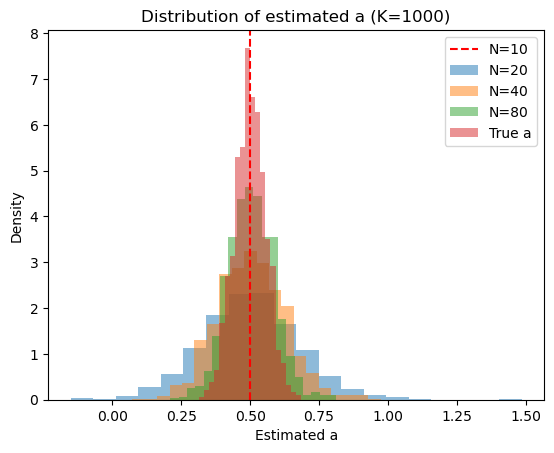

In [82]:
# *** 実装しなさい 
import numpy as np
import matplotlib.pyplot as plt

true_a = 0.5
true_b = 1.0
x_min = -10
x_max = 10
sigma = 3
K = 1000

N_values = [10, 20, 40, 80]
a_estimates = {N: [] for N in N_values}

for N in N_values:
    for _ in range(K):
        # N個のデータ生成
        xys_n = gen_xys(true_a, true_b, N, x_min, x_max, sigma)
        # 正規方程式でa, bを推定
        est_a, _ = opt_ab(xys_n)
        a_estimates[N].append(est_a)

plt.figure()
for N in N_values:
    # density=True と alpha=0.5 を指定
    plt.hist(a_estimates[N], bins=20, density=True, alpha=0.5)

# 真の値の位置に縦線を引く
plt.axvline(true_a, color='red', linestyle='--', label='True a') 
plt.legend([f'N={N}' for N in N_values] + ['True a'])
plt.title('Distribution of estimated a (K=1000)')
plt.xlabel('Estimated a')
plt.ylabel('Density')
plt.show()


おおむね $N$ が大きいほど真の $a$ の周りでの推定値のバラツキが小さい様子が見て取れるだろう．

もう少し定量的に $N$ ごとのバラツキの違いを調べるために，横軸に $N$，縦軸に各 $N$ に対する $a$ の $K$ 個の推定値 $a_1, a_2, \dots, a_K$ の標準偏差

$$
\sqrt{\frac{1}{K}\sum_{k=1}^{K} (a_k - {\bar a})^2} = \sqrt{\frac{1}{K}\sum_{k=1}^{K}a_k^2 - \left(\frac{1}{K}\sum_{k=1}^{K}a_k\right)^2}
$$

をとってグラフを描いてみよう（上式左辺の ${\bar a}$ は $a_1, \dots, a_K$ の平均値）．

まず準備として `xs = [x1, x2, ..., x_N]` を与えたときにそれらの標準偏差を返す関数 `std(xs)` を実装しなさい：

In [83]:
def std(xs):
    # *** 実装しなさい ***

    if not xs:
        return 0.0
    
    K = len(xs)
    # 1. 平均を計算 (1/K * Σ a_k)
    mean_a = sum(xs) / K
    
    # 2. 二乗の平均を計算 (1/K * Σ a_k^2)
    mean_a_sq = sum(a**2 for a in xs) / K
    
    # 3. 分散を計算 (Variance = 平均(a^2) - (平均(a))^2)
    variance = mean_a_sq - mean_a**2
    
    # 計算誤差で負になる可能性を考慮
    if variance < 0:
        variance = 0
        
    # 4. 標準偏差を計算
    std_dev = variance**0.5
    
    return std_dev

実装できたら，平均 0，分散 1 の正規分布から生成した 1000 個のデータを `std` に与えて，結果が正しそうかテストしなさい：

In [84]:
xs = []
for _ in range(1000):
    xs.append(random.gauss(0, 1))
std(xs)

1.0066680990652717

次に，$N = 10, 20, 40, 80, 160, 320$ のそれぞれについて `gen_xys` を用いて $N$ 個のデータ点を生成して $a$ の推定値を得ることを $K = 1000$ 回くり返し，それら $K$ 個の推定値の標準偏差をリストに集めて，横軸に $N$，縦軸に各 $N$ に対する推定値の標準偏差をとったグラフを描いてみなさい：

上のグラフは，パラメータ $a$ の推定値と真の値のずれをある程度以下にするには，大体いくつくらいのデータを集める必要があるかを示している．

この曲線は理論的には（つまり $K \rightarrow \infty$ のとき）どのような曲線になるだろうか．興味がある人は考えてみなさい．

---

お疲れ様でした．以上で今回の課題は全て終わりです．

## 課題提出の前の注意
* このセルをクリックしてから，メニューの "Run" から <font color="red">"Run All Above Selected Cells"</font> を選択し，全てのセルが正しく実行されることを確認すること
* 取り組んだ必須課題とチャレンジ課題のセルが全て正しく実行され，結果が表示されていることを確認すること
* 各セルの実行結果が表示されている状態で保存のボタンを押してノートブックを保存すること
* 上記のようにして，実行結果まで含めて保存してからノートブックを提出すること．

**初級編3: おわり**  